In [76]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [75]:
with open('cam_data.json', 'r') as file:
    cam_data = json.load(file)

    

In [76]:
scaler = MinMaxScaler()
cam0 = np.array(list(map(lambda x: scaler.fit_transform(x['0']), cam_data)))
cam1 = np.array(list(map(lambda x: scaler.fit_transform(x['1']), cam_data)))

In [77]:
cam0_avg = cam0.mean(axis=0).flatten().tolist()
cam0_max = cam0.max(axis=0).flatten().tolist()
cam1_avg = cam1.mean(axis=0).flatten().tolist()
cam1_max = cam1.max(axis=0).flatten().tolist()

In [78]:
with open('cam_agregated.json', 'w') as file:
    json.dump([
        {'avg': cam0_avg, 'max': cam0_max},
        {'avg': cam1_avg, 'max': cam1_max},
    ], file)

### Run predictions

In [113]:
from keras.models import load_model, Model
import keras.backend as K
from keras.layers.core import Lambda
import tensorflow as tf

In [114]:
model = load_model('models/model_2.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                62730     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total para

In [116]:
%run utils.py

In [8]:
image_size = 28
frame_duration = 1.0
overlap = 0.5
X, y = make_data_pipeline(file_names,labels,image_size,frame_duration,overlap)

Generating training data...
Interpolating 117/117nterpolating 53/117Interpolating 99/117Interpolating 1/112Interpolating 52/112Interpolating 100/112Interpolating 1/111Interpolating 49/111Interpolating 94/111Interpolating 1/109Interpolating 50/109Interpolating 91/109Interpolating 1/113Interpolating 63/113Interpolating 107/113Interpolating 1/104Interpolating 54/104Interpolating 99/104Interpolating 1/101Interpolating 51/101Interpolating 95/101Interpolating 1/102Interpolating 53/102Interpolating 96/102Interpolating 1/107Interpolating 53/107Interpolating 99/107Interpolating 1/113Interpolating 53/113Interpolating 99/113Interpolating 1/115Interpolating 53/115Interpolating 100/115Interpolating 1/139Interpolating 52/139Interpolating 98/139Interpolating 1/123Interpolating 42/123Interpolating 81/123Interpolating 102/123Interpolating 117/123Interpolating 1/118Interpolating 23/118Interpolating 44/118Interpolating 54/118Interpolating 81/118Interpolating 101/118Interpolating 115/118Interpolating 1/12

In [117]:
predictions = model.predict(X)
predictions = np.argmax(predictions, axis=1)

In [118]:
predictions.shape, y.shape

((1821,), (1821,))

In [119]:
tp = X[(predictions == y) & (y == 1)]
tn = X[(predictions == y) & (y == 0)]
fp = X[(predictions != y) & (y == 0)]
fn = X[(predictions != y) & (y == 1)]

In [120]:
tp.shape[0], tn.shape[0], fp.shape[0], fn.shape[0],

(871, 848, 66, 36)

In [121]:
def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def naive_cam(input_model, images):
    conv_output = model.layers[2].output 
    cam_extractor = K.function([model.input], [conv_output])
    cam = cam_extractor([images])
    cam = cam[0]
    cam = np.maximum(cam, 0)
    cam = np.mean(cam, axis=3)
    cam = np.mean(cam, axis=0)
    heatmap = cam / np.max(cam)
    return cam, heatmap

def grad_cam(input_model, images, category_index):
    nb_classes = 2
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    last = Lambda(target_layer, output_shape=target_category_loss_output_shape)(input_model.output)
    model = Model(inputs=input_model.input, outputs=last)
    loss = K.sum(model.layers[-1].output)
    conv_output = model.layers[2].output
    grads = normalize(K.gradients(loss, conv_output)[0])
    
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])
    
    output, grads_val = gradient_function([images])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)
    scaler = MinMaxScaler()
    

    return cam, heatmap


In [134]:
tp_cam, tp_heat = naive_cam(model, tp)
tn_cam, tn_heat = naive_cam(model, tn)
fp_cam, fp_heat = naive_cam(model, fp)
fn_cam, fn_heat = naive_cam(model, fn)

In [135]:
tp_heat

array([[0.04378912, 0.05170663, 0.05170663, 0.05170663, 0.05170663,
        0.05170663, 0.05170663, 0.06695658, 0.12156811, 0.17940971,
        0.25927743, 0.32844135, 0.3436549 , 0.34585285, 0.36080226,
        0.3656646 , 0.3401665 , 0.26426873, 0.16343482, 0.08352603,
        0.05937237, 0.05170663, 0.05170663, 0.05170663, 0.05170663,
        0.05170663, 0.05170663, 0.0423391 ],
       [0.04471947, 0.04822186, 0.04822186, 0.04822186, 0.04822186,
        0.04822186, 0.06924836, 0.11730471, 0.16455495, 0.2444062 ,
        0.3330559 , 0.3831733 , 0.41298681, 0.43018454, 0.43995667,
        0.44895318, 0.4426713 , 0.38199386, 0.27919126, 0.15666077,
        0.08234721, 0.05902914, 0.04822186, 0.04822186, 0.04822186,
        0.04822186, 0.04822186, 0.0361186 ],
       [0.04471947, 0.04822186, 0.04822186, 0.04822186, 0.04822186,
        0.07421067, 0.13214591, 0.19972694, 0.26930156, 0.34289938,
        0.37877202, 0.40929198, 0.41663772, 0.42461982, 0.42924532,
        0.44105956, 0.4366

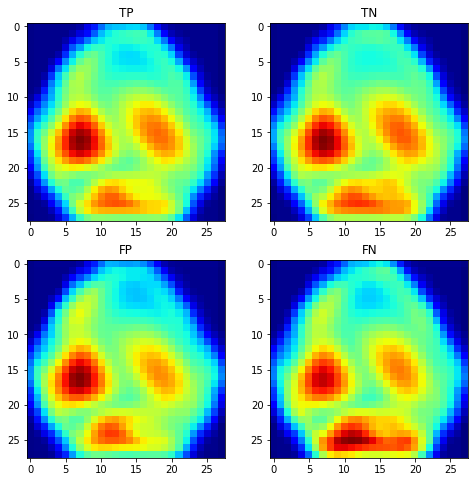

In [136]:
fig= plt.figure(figsize=(8, 8))
rows = 2
cols = 2

fig.add_subplot(rows, cols, 1)
plt.imshow(tp_heat, cmap='jet')
plt.title('TP')

fig.add_subplot(rows, cols, 2)
plt.imshow(tn_heat, cmap='jet')
plt.title('TN')

fig.add_subplot(rows, cols, 3)
plt.imshow(fp_heat, cmap='jet')
plt.title('FP')

fig.add_subplot(rows, cols, 4)
plt.imshow(fn_heat, cmap='jet')
plt.title('FN')
plt.show()

In [126]:
tp_cam, tp_heat = grad_cam(model, tp, 1)
tn_cam, tn_heat = grad_cam(model, tn, 0)
fp_cam, fp_heat = grad_cam(model, fp, 1)
fn_cam, fn_heat = grad_cam(model, fn, 0)

In [129]:
tp_heat

array([[0.9985829 , 0.9985706 , 0.9985706 , 0.9985706 , 0.9985706 ,
        0.9985706 , 0.9985706 , 0.99859816, 0.99861246, 0.99869907,
        0.9989173 , 0.9992089 , 0.9992581 , 0.9991707 , 0.99893653,
        0.9986955 , 0.9987047 , 0.99879026, 0.9987313 , 0.998648  ,
        0.9986449 , 0.9985706 , 0.9985706 , 0.9985706 , 0.9985706 ,
        0.9985706 , 0.9985706 , 0.9986151 ],
       [0.99860334, 0.99856204, 0.99856204, 0.99856204, 0.99856204,
        0.99856204, 0.99858415, 0.99855614, 0.9986174 , 0.9985028 ,
        0.9987844 , 0.9992329 , 0.9992887 , 0.99918395, 0.99903893,
        0.99902046, 0.9988217 , 0.9988074 , 0.9988626 , 0.9987381 ,
        0.998677  , 0.9986486 , 0.99856204, 0.99856204, 0.99856204,
        0.99856204, 0.99856204, 0.9985964 ],
       [0.99860334, 0.99856204, 0.99856204, 0.99856204, 0.99856204,
        0.9985851 , 0.9985627 , 0.9986046 , 0.99847096, 0.9985616 ,
        0.99880284, 0.99893963, 0.99895155, 0.9988901 , 0.9988674 ,
        0.9989437 , 0.9989

In [130]:
scaler = MinMaxScaler()
tp_heat = scaler.fit_transform(tp_heat)
tn_heat = scaler.fit_transform(tn_heat)
fp_heat = scaler.fit_transform(fp_heat)
fn_heat = scaler.fit_transform(fn_heat)

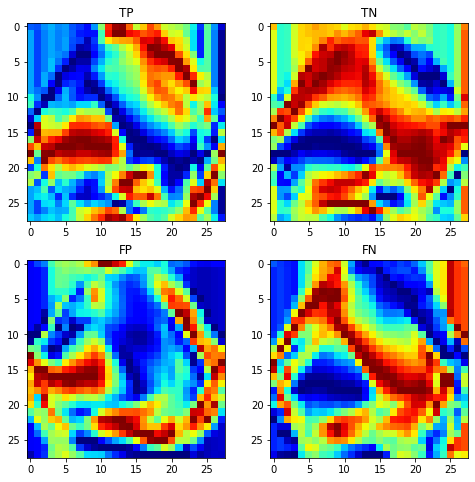

In [131]:
from matplotlib.colors import Normalize

fig= plt.figure(figsize=(8, 8))
rows = 2
cols = 2

fig.add_subplot(rows, cols, 1)
plt.imshow(tp_heat, cmap='jet')
plt.title('TP')

fig.add_subplot(rows, cols, 2)
plt.imshow(tn_heat, cmap='jet')
plt.title('TN')

fig.add_subplot(rows, cols, 3)
plt.imshow(fp_heat, cmap='jet')
plt.title('FP')

fig.add_subplot(rows, cols, 4)
plt.imshow(fn_heat, cmap='jet')
plt.title('FN')
plt.show()

0.99797285

In [137]:
tp_heat = tp_heat.flatten().tolist()
tn_heat = tn_heat.flatten().tolist()
fp_heat = fp_heat.flatten().tolist()
fn_heat = fn_heat.flatten().tolist()

In [138]:
with open('../proyecto-insideout/data/cam_confusion.json', 'w') as file:
    json.dump({
        'truePositive': tp_heat,
        'trueNegative': tn_heat,
        'falsePositive': fp_heat,
        'falseNegative': fn_heat,
    }, file)

784